In [1]:
# ===============================
# CÉLULA 1 – Imports
# ===============================
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.ensemble import VotingClassifier


In [2]:
# ===============================
# CÉLULA 2 – Carregar Dataset
# ===============================
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

# Converter target: normal → 0, attack → 1
train["target"] = train["target"].map({"normal": 0, "attack": 1})

# Separar features e target
X = train.drop(["id", "target"], axis=1)
y = train["target"]

# Separar treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [3]:
# ===============================
# CÉLULA 3 – Escalar Dados
# ===============================
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test.drop("id", axis=1))


In [4]:
# ===============================
# CÉLULA 4 – Treinar XGBoost / LightGBM / CatBoost
# ===============================

models = {
    "XGBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss"
    ),
    "LightGBM": LGBMClassifier(random_state=42),
    "CatBoost": CatBoostClassifier(random_state=42, verbose=0)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    acc = accuracy_score(y_val, preds)
    results[name] = acc
    print(f"{name} → Acurácia: {acc:.5f}")

best_model_name = max(results, key=results.get)
print("\nMelhor modelo inicial:", best_model_name)


c:\Users\bamfn\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:35:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost → Acurácia: 0.91947


c:\Users\bamfn\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] O sistema não pode encontrar o arquivo especificado
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\bamfn\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\bamfn\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\bamfn\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^

[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.063914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086


c:\Users\bamfn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LightGBM → Acurácia: 0.91964
CatBoost → Acurácia: 0.91930

Melhor modelo inicial: LightGBM


In [5]:
# ===============================
# CÉLULA 5 – GridSearchCV
# ===============================

if best_model_name == "XGBoost":
    model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    param_grid = {
        "n_estimators": [300, 500, 700],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.03, 0.05, 0.07],
        "subsample": [0.8, 0.9, 1.0]
    }

elif best_model_name == "LightGBM":
    model = LGBMClassifier(random_state=42)
    param_grid = {
        "n_estimators": [300, 500, 700],
        "max_depth": [4, 6, 8],
        "learning_rate": [0.03, 0.05, 0.07],
        "num_leaves": [31, 63, 127]
    }

else:  # CatBoost
    model = CatBoostClassifier(random_state=42, verbose=0)
    param_grid = {
        "iterations": [300, 500, 700],
        "depth": [4, 6, 8],
        "learning_rate": [0.03, 0.05, 0.07]
    }

grid = GridSearchCV(
    model,
    param_grid,
    scoring="accuracy",
    cv=3,
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Melhores parâmetros:", grid.best_params_)
print("Melhor acurácia média (CV):", grid.best_score_)

best_model = grid.best_estimator_


[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.150306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [6]:
# ===============================
# CÉLULA 6 – Avaliação Final
# ===============================
preds = best_model.predict(X_val_scaled)

print("Acurácia final:", accuracy_score(y_val, preds))
print("\n", classification_report(y_val, preds))


c:\Users\bamfn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acurácia final: 0.9199862045180204

               precision    recall  f1-score   support

           0       0.86      1.00      0.93      2900
           1       1.00      0.84      0.91      2899

    accuracy                           0.92      5799
   macro avg       0.93      0.92      0.92      5799
weighted avg       0.93      0.92      0.92      5799



In [7]:
# ===============================
# CÉLULA 7 – Ensemble dos 2 Melhores
# ===============================

# Ordenar modelos por acurácia
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)
top1, top2 = sorted_results[:2]

print("Top 2 modelos:", top1[0], "e", top2[0])

# Criar instâncias dos 2 melhores
def get_model(name):
    if name == "XGBoost":
        return XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
    if name == "LightGBM":
        return LGBMClassifier(random_state=42)
    return CatBoostClassifier(random_state=42, verbose=0)

m1 = get_model(top1[0])
m2 = get_model(top2[0])

# Treinar ambos
m1.fit(X_train_scaled, y_train)
m2.fit(X_train_scaled, y_train)

# Ensemble – votação suave
ensemble = VotingClassifier(
    estimators=[("m1", m1), ("m2", m2)],
    voting="soft"
)

ensemble.fit(X_train_scaled, y_train)

ensemble_preds = ensemble.predict(X_val_scaled)

print("Acurácia Ensemble:", accuracy_score(y_val, ensemble_preds))


Top 2 modelos: LightGBM e XGBoost
[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086


c:\Users\bamfn\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:25:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.087181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086


c:\Users\bamfn\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:25:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Acurácia Ensemble: 0.9194688739437834


c:\Users\bamfn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [8]:
# ===============================
# CÉLULA 8 – Criar arquivo de envio
# ===============================

# Escolher qual usar
use_ensemble = True   # << troque para False se quiser o best_model

final_model = ensemble if use_ensemble else best_model

final_model.fit(X_train_scaled, y_train)

test_preds = final_model.predict(test_scaled)

# Converter 0/1 para 'normal' / 'attack'
test_preds_text = np.where(test_preds == 1, "attack", "normal")

submission = pd.DataFrame({
    "id": test["id"],
    "target": test_preds_text
})

submission.to_csv("submission.csv", index=False)
print("Arquivo 'submission.csv' criado!")


[LightGBM] [Info] Number of positive: 11597, number of negative: 11596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.091912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8908
[LightGBM] [Info] Number of data points in the train set: 23193, number of used features: 524
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500022 -> initscore=0.000086
[LightGBM] [Info] Start training from score 0.000086


c:\Users\bamfn\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:25:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\bamfn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Arquivo 'submission.csv' criado!


c:\Users\bamfn\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<Figure size 600x500 with 0 Axes>

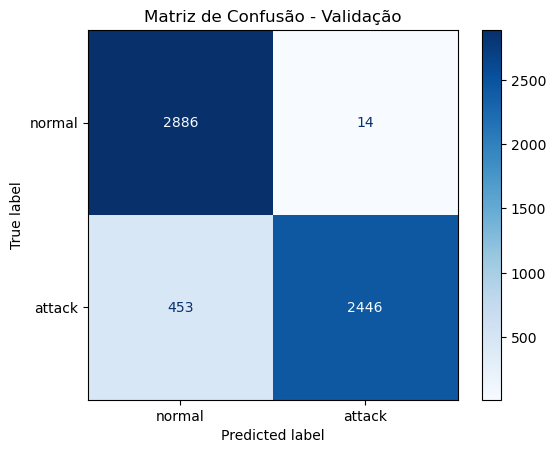

In [9]:
# ===============================
# CÉLULA 9 – Matriz de Confusão
# ===============================
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Usar o mesmo modelo final escolhido lá na Célula 8
final_model = ensemble if use_ensemble else best_model

# Prever no conjunto de validação
val_preds = final_model.predict(X_val_scaled)

# Calcular matriz de confusão
cm = confusion_matrix(y_val, val_preds)

# Exibir
plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(cm, display_labels=["normal", "attack"])
disp.plot(values_format="d", cmap="Blues")
plt.title("Matriz de Confusão - Validação")
plt.show()
